<a href="https://colab.research.google.com/github/Vo-Linh/Project_AI/blob/main/Face_Mask_Detection_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Mask Detection use Pytorch - FastetRCNN 😷

Dataset form kaggle: https://www.kaggle.com/andrewmvd/face-mask-detection


## Download dataset use kaggle API

In [1]:
# Upload kaggle.json
from google.colab import files 
kaggle = files.upload()

Saving kaggle.json to kaggle (1).json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/face-mask-detection

kaggle.json
face-mask-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip /content/face-mask-detection.zip

Archive:  /content/face-mask-detection.zip
replace annotations/maksssksksss0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss1

In [1]:
# Import package require
import numpy as np
import pandas as pd # data processing
from bs4 import BeautifulSoup # read file format XML
import torch
import torchvision
from torchvision import transforms, datasets, models
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os

for dirname, _, filenames in os.walk('/content/annotations'):
    i = 0
    for filename in filenames:
      i+= 1
      # print(os.path.join(dirname, filename))
    
    print(f'Total file {i}')


Total file 853


## Preprocessing and prepare data 
1. Draw square bound on target
2. Split label into 3 class: with mask, ware make incorrect
3. Data Augment


In [2]:
def generate_box(obj):
  '''
  obj (object): result form read file
  ----------
  return [xmin, ymin, xmax, ymax]
  '''

  xmin = int(obj.find('xmin').text)
  ymin = int(obj.find('ymin').text)
  xmax = int(obj.find('xmax').text)
  ymax = int(obj.find('ymax').text)

  return [xmin, ymin, xmax, ymax]

def generate_label(obj):
  '''
  obj (object): result from read file 
  ----------
  return 2: mask weared incorrect
         1: with masd 
         0: without mask
  '''

  if obj.find('name').text == 'with_mask':
    return 1
  elif obj.find('name').text == 'mask_weared_incorrect':
    return 2
  return 0

def generate_target(image_id, file):
  '''
  image_id: id of image 
  file: path of data set 
  --------
  return dictionary target include boxes, label, imgafe_id
  '''
  with open(file) as f:
    data = f.read()
    soup = BeautifulSoup(data, 'xml')
    objects = soup.find_all('object')

    num_objs = len(objects)

    # Bounding boxes for object
    boxes = []
    labels = []
    for i in objects:
      boxes.append(generate_box(i))
      labels.append(generate_label(i))
    boxes = torch.as_tensor(boxes, dtype = torch.float32)
    labels = torch.as_tensor(labels, dtype = torch.int64)
    img_id = torch.tensor([image_id])

    # Annotation is in dictionary format
    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = img_id
    
    return target 

## Visualize data 

In [3]:
target_103 = generate_target(103, '/content/annotations/maksssksksss103.xml')
target_103

{'boxes': tensor([[ 42.,  54.,  94., 110.],
         [188.,  46., 236., 106.],
         [261.,  88., 303., 130.],
         [368., 112., 400., 151.]]),
 'image_id': tensor([103]),
 'labels': tensor([1, 1, 1, 1])}

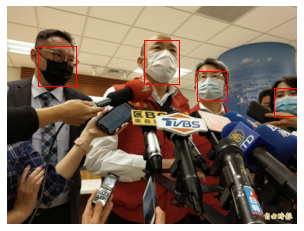

In [4]:
# Convert img to tesor
convert_tensor = transforms.ToTensor()
img_103 = Image.open('/content/images/maksssksksss103.png')
img_103_tensor = convert_tensor(img_103)

fig, ax = plt.subplots(1)
ax.imshow(img_103_tensor.permute(1, 2, 0))
for box in target_103["boxes"]:
    xmin, ymin, xmax, ymax = box

    # Create a Rectangle patch
    rect = patches.Rectangle((xmin,ymin),
                             (xmax-xmin),
                             (ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)


plt.axis(False)
plt.show()

In [ ]:
imgs = list(sorted(os.listdir('/content/images')))
labels = list(sorted(os.listdir('/content/annotations')))
imgs

In [6]:
class MaskDataset(object):
  def __init__(self, transforms):
    self.transforms = transforms

    #ensure that they are aligned
    self.imgs = list(sorted(os.listdir('/content/images')))
    # self.labels = list(sorted(os.listdir('/content/annotations')))

  def __getitem__(self, idx):
    file_images = 'maksssksksss' + str(idx) + '.png'
    file_label = 'maksssksksss' + str(idx) + '.xml'
    img_path = os.path.join('/content/images', file_images)
    label_path = os.path.join('/content/annotations', file_label)
    img = Image.open(img_path).convert('RGB')

    # Generate labels
    target = generate_target(idx, label_path)

    if self.transforms is not None:
        img = self.transforms(img)

    return img, target

  def __len__(self):
    return len(self.imgs)

In [7]:
data_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((224, 224))
])

def collate_fn(batch):
  return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=4, 
                                          collate_fn=collate_fn)

In [8]:
# check gpu
!nvidia-smi
torch.cuda.is_available()

Fri Jan 14 03:40:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

## Model 


In [9]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [10]:
model = get_model_instance_segmentation(3)

### Train model 

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([0, 1, 0], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 2], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

In [12]:
epochs = 10
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params= params,
                            lr = 0.005,
                            momentum = 0.9,
                            weight_decay = 0.0005)

for epoch in range(epochs):
  model.train()
  i = 0
  epoch_loss = 0
  for imgs, annotations in data_loader:
    i += 1
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    loss_dict = model(imgs, annotations)
    losses = sum(loss for loss in loss_dict.values())
    # print(annotations[0])
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    epoch_loss += losses

  print(f'epochs {epoch+1}: loss = {epoch_loss}')

epochs 1: loss = 871.08447265625
epochs 2: loss = 836.9586791992188
epochs 3: loss = 811.861572265625
epochs 4: loss = 810.7893676757812
epochs 5: loss = 796.0355834960938
epochs 6: loss = 793.2413330078125
epochs 7: loss = 785.71533203125
epochs 8: loss = 762.3860473632812
epochs 9: loss = 771.4828491210938
epochs 10: loss = 756.2557373046875


In [13]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [22]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

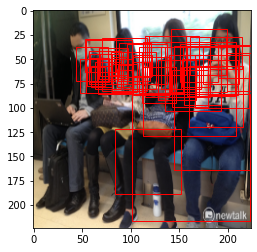

In [24]:
plot_image(imgs[2], preds[2])